# Problem Introduction

## Dataset Description & Loading

### Forest CoverType Dataset

This dataset contains **581,012** observations of **30 × 30 m** forest patches from Roosevelt National Forest in northern Colorado. Each sample is described by **54 cartographic features** (elevation, slope, aspects, hydrology distances, hillshade at different times, plus binary soil- and wilderness-area indicators). The goal is to classify each sample into one of **seven forest cover types** (e.g. Spruce/Fir, Lodgepole Pine, Ponderosa Pine, etc.), based purely on map-derived data—no imagery involved. The data were collected via U.S. Forest Service and USGS systems, include no missing values, and cover diverse ecological zones. Originally published in 1998 by researchers at Colorado State University (Blackard & Dean), this dataset has since become a standard benchmark for multiclass forest-type classification tasks.

Source: https://archive.ics.uci.edu/dataset/31/covertype

In [4]:
# Libraries

import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap 
import warnings
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from models.train_model import train_models
from models.predict_model import evaluate_models

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.exceptions import ConvergenceWarning

from xgboost import XGBClassifier


RANDOM_SEED = 18

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Dataset Uploading
from data.make_dataset import load_dataset
df, target_col, quantitative_cols, binary_cols = load_dataset()


# --- Output summaries ---
print(f"✅ Quantitative features ({len(quantitative_cols)}):\n", quantitative_cols)
print(f"\n✅ Binary features ({len(binary_cols)}):\n", binary_cols)

✅ Quantitative features (10):
 ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

✅ Binary features (44):
 ['Wilderness_Area1', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']


# EDA

## General Information


In [5]:
print("Dataset Dimensions:", df.shape)
print("\nPrimeras filas:")
print(df.head())

print("\nData Types:")
print(df.dtypes.value_counts())
print(df.dtypes)

Dataset Dimensions: (581012, 55)

Primeras filas:
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235    

## Missing values and duplicates Check



In [6]:
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if missing_values.empty:
    print("✅ No missing values detected in the dataset.")
else:
    print("⚠️ Missing values found:")
    display(missing_values)

✅ No missing values detected in the dataset.


In [7]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()

if duplicate_count == 0:
    print("✅ No duplicate rows detected in the dataset.")
else:
    print(f"⚠️ {duplicate_count} duplicate rows found in the dataset.")

✅ No duplicate rows detected in the dataset.


## Class distribution analysis

As shown in the following images, the dataset suffers from significant class imbalance, which must be taken into account in the classification phase.



Target class distribution:
Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


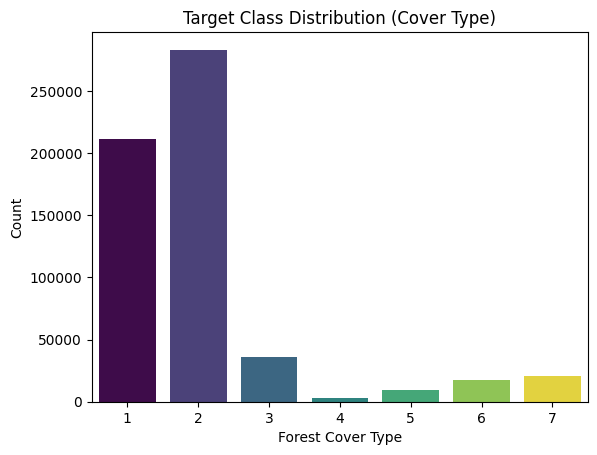

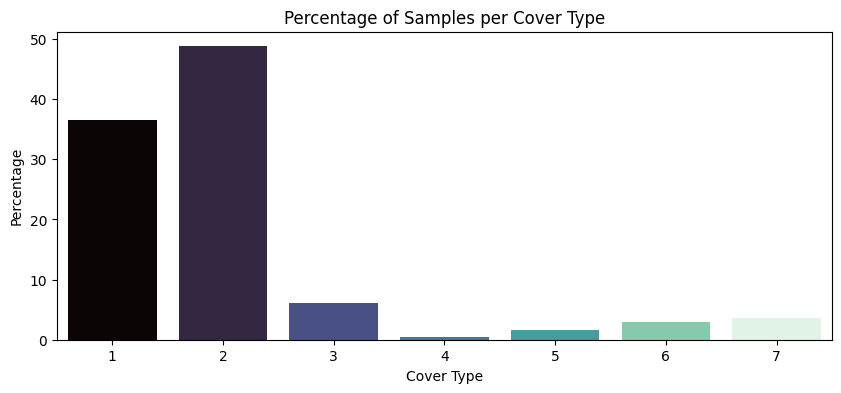

In [8]:
# Print class distribution counts
print("\nTarget class distribution:")
print(df[target_col].value_counts().sort_index())

sns.countplot(data=df, x=target_col, hue=target_col, palette="viridis", legend=False)
plt.title("Target Class Distribution (Cover Type)")
plt.xlabel("Forest Cover Type")
plt.ylabel("Count")
plt.show()

# Compute class counts and percentages
class_counts = df[target_col].value_counts().sort_index()
class_percent = class_counts / len(df) * 100

# Prepare DataFrame for barplot
bar_df = pd.DataFrame({
    "CoverType": class_counts.index,
    "Percentage": class_percent.values
})

plt.figure(figsize=(10, 4))
sns.barplot(data=bar_df, x="CoverType", y="Percentage", hue="CoverType", palette="mako", legend=False)
plt.title("Percentage of Samples per Cover Type")
plt.ylabel("Percentage")
plt.xlabel("Cover Type")
plt.show()

### Descriptive Statistics Summary (Excluding Binary Columns)

This table summarizes the central tendency and dispersion of the main continuous variables in the Forest Cover Type dataset:

- **Elevation**: Ranges from **1859m to 3858m** with a mean of ~2960m, indicating substantial terrain variation across forested mountain regions.
- **Aspect**: Uniformly spans from **0° to 360°**, showing a wide distribution of terrain orientations. The mean (~156°) suggests a slight dominance of SE-facing slopes.
- **Slope**: Most values are modest, with **median = 13°** and max at **66°**.

- **Horizontal & Vertical Distance to Hydrology**:
  - Horizontal: Average ~269m from water, but some points lie over **1.3 km** away.
  - Vertical: Ranges from **-173m to +601m**, with negative values representing points uphill from water sources.

- **Horizontal Distance to Roadways**: Mean ~2.3 km; ranges up to **7.1 km**, suggesting many remote points.

- **Hillshade (9am, Noon, 3pm)**:
  - Values follow the expected sun cycle with **higher illumination around noon**.

- **Horizontal Distance to Fire Points**: Wide spread with a **mean of ~1980m**; some samples are very close (**0m**) and others very far (**7173m**).

In [9]:
print("\nDescriptive Statistics (excluding binary variable columns):")
print(df[quantitative_cols].describe())


Descriptive Statistics (excluding binary variable columns):
           Elevation         Aspect          Slope  \
count  581012.000000  581012.000000  581012.000000   
mean     2959.365301     155.656807      14.103704   
std       279.984734     111.913721       7.488242   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     581012.000000                   581012.000000   
mean                         269.428217                       46.418855   
std                          212.549356                       58.295232   
min                            0.000000                     -173.000000   
25%                          108.000000                        7.000000   
50

### Distribution of Soil Types and Wilderness Areas

The first histogram shows the **relative frequency of each `Soil_Type`** variable in the dataset. It is evident that a few soil types dominate the data—most notably `Soil_Type29`, which represents nearly 20% of the samples, followed by `Soil_Type30`, `Soil_Type23`, and others. In contrast, many soil types occur very infrequently, with some appearing in less than 1% of the observations. This imbalance should be considered in downstream modeling, especially if certain soil types are predictive of forest cover.

The second histogram depicts the **relative frequency of each `Wilderness_Area`**. Two classes—`Wilderness_Area1` and `Wilderness_Area3`—account for the majority of the dataset, each with more than 40% of the samples. The remaining two classes (`Wilderness_Area2` and `Wilderness_Area4`) are underrepresented. This skewed distribution may influence model performance and should be accounted for, potentially via stratified sampling or class balancing techniques.

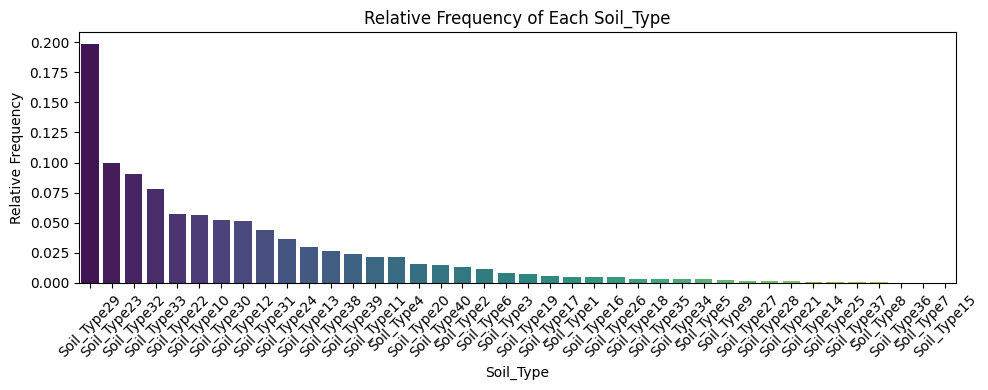

Soil_Type columns are mutually exclusive (exactly one per row).


In [10]:
# --- Soil_Type Analysis ---
soil_type_cols = [col for col in binary_cols if col.startswith('Soil_Type')]
soil_type_freq = df[soil_type_cols].sum().sort_values(ascending=False) / len(df)

# Convert to DataFrame to allow hue assignment
soil_df = soil_type_freq.reset_index()
soil_df.columns = ['Soil_Type', 'Frequency']

# Plot histogram for Soil_Type (with hue to avoid FutureWarning)
plt.figure(figsize=(10, 4))
sns.barplot(data=soil_df, x="Soil_Type", y="Frequency", hue="Soil_Type", palette="viridis", legend=False)
plt.xticks(rotation=45)
plt.ylabel("Relative Frequency")
plt.title("Relative Frequency of Each Soil_Type")
plt.tight_layout()
plt.show()

# Mutual exclusivity check
soil_type_sum = df[soil_type_cols].sum(axis=1)
non_exclusive_soil = (soil_type_sum != 1).sum()
if non_exclusive_soil == 0:
    print("Soil_Type columns are mutually exclusive (exactly one per row).")
else:
    print(f"{non_exclusive_soil} rows violate Soil_Type mutual exclusivity.")


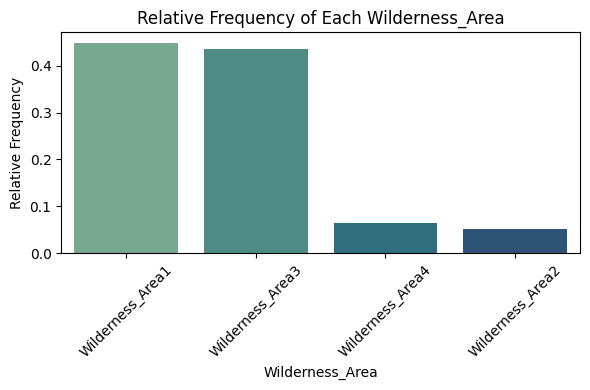

Wilderness_Area columns are mutually exclusive (exactly one per row).


In [11]:
# --- Wilderness_Area Analysis ---
wilderness_cols = [col for col in binary_cols if col.startswith('Wilderness_Area')]
wilderness_freq = df[wilderness_cols].sum().sort_values(ascending=False) / len(df)

# Convert to DataFrame to allow hue assignment
wilderness_df = wilderness_freq.reset_index()
wilderness_df.columns = ['Wilderness_Area', 'Frequency']

# Plot histogram for Wilderness_Area (with hue to avoid FutureWarning)
plt.figure(figsize=(6, 4))
sns.barplot(data=wilderness_df, x="Wilderness_Area", y="Frequency", hue="Wilderness_Area", palette="crest", legend=False)
plt.xticks(rotation=45)
plt.ylabel("Relative Frequency")
plt.title("Relative Frequency of Each Wilderness_Area")
plt.tight_layout()
plt.show()

# Mutual exclusivity check
wilderness_sum = df[wilderness_cols].sum(axis=1)
non_exclusive_wilderness = (wilderness_sum != 1).sum()
if non_exclusive_wilderness == 0:
    print("Wilderness_Area columns are mutually exclusive (exactly one per row).")
else:
    print(f"{non_exclusive_wilderness} rows violate Wilderness_Area mutual exclusivity.")

## Feature Relationship Analysis


The correlation matrix shows that most quantitative features exhibit weak to moderate linear relationships with one another. Notably, `Hillshade_9am` and `Hillshade_3pm` are strongly correlated, likely due to similar terrain shading behavior throughout the day. Other features such as `Aspect` and `Slope` show little linear correlation with the rest of the dataset, suggesting they may capture more independent or nonlinear patterns.

The mutual information matrix complements this by revealing **nonlinear dependencies** not captured by correlation. For example, `Hillshade_9am`, `Hillshade_Noon`, and `Aspect` display higher mutual information with other features, highlighting their potential relevance in models capable of learning nonlinear interactions (e.g., tree-based models or ensemble methods).

### Correlation matrix

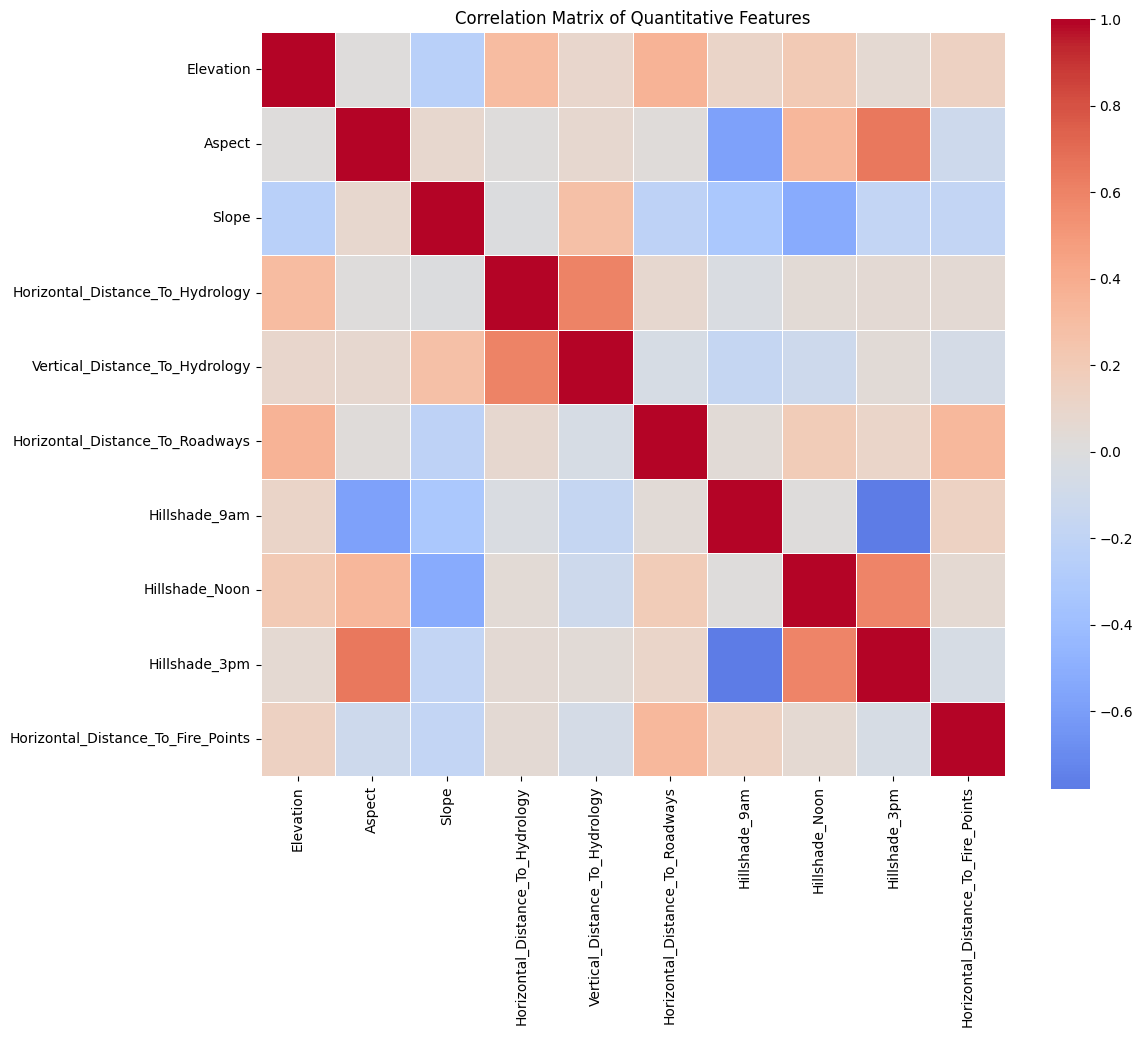

In [12]:
# Compute correlation matrix for quantitative features
corr = df[quantitative_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=0.5, annot=False)
plt.title("Correlation Matrix of Quantitative Features")
plt.show()


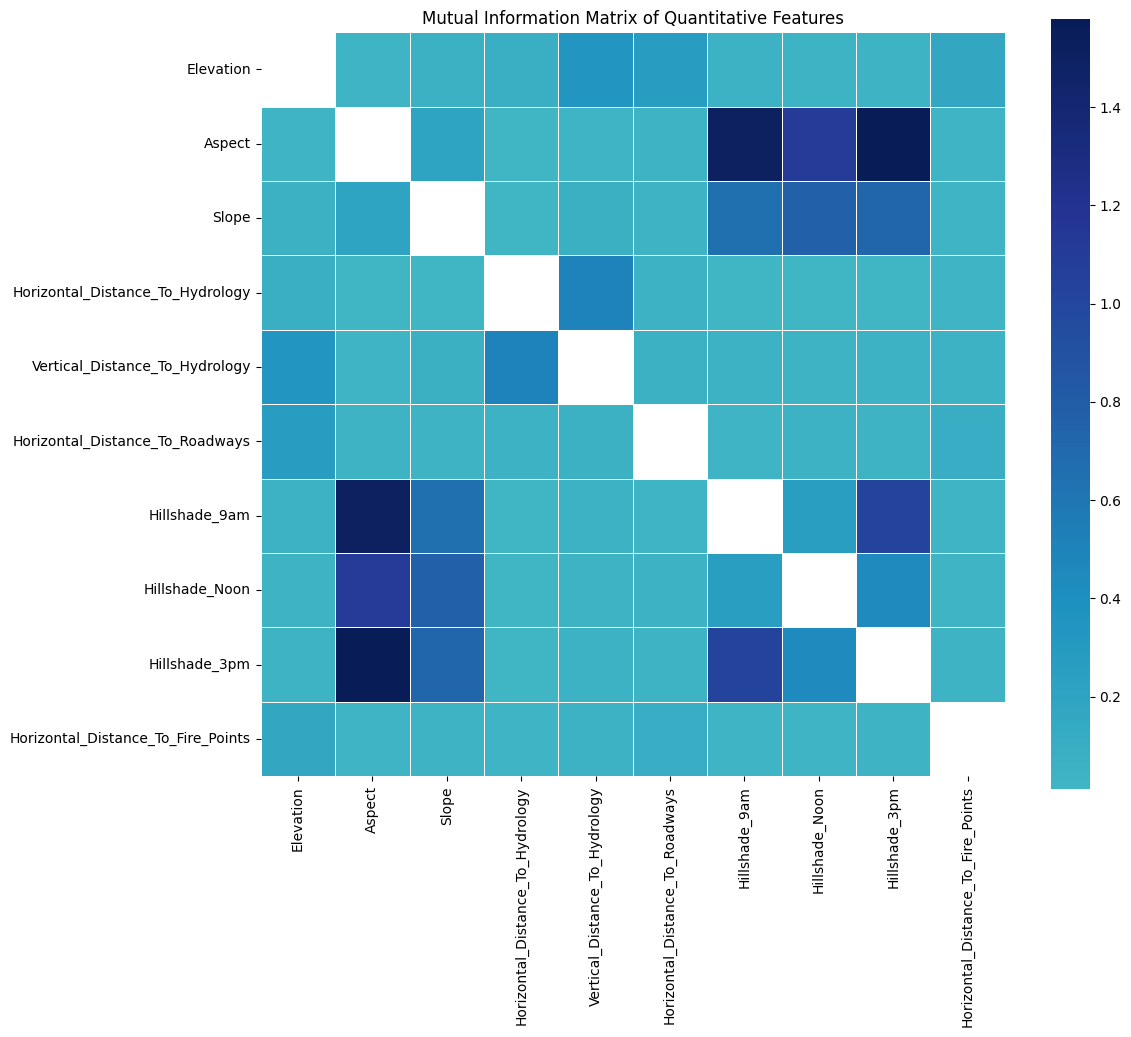

In [13]:
# Compute mutual information between all pairs (MI is not symmetric like correlation, so we fake a matrix)
mi_matrix = pd.DataFrame(index=quantitative_cols, columns=quantitative_cols)

for col_x in quantitative_cols:
    X = df[quantitative_cols].copy()
    y = df[col_x]
    X = X.drop(columns=[col_x])
    
    mi = mutual_info_regression(X, y, discrete_features=False, random_state=RANDOM_SEED)
    
    for i, col_y in enumerate(X.columns):
        mi_matrix.loc[col_x, col_y] = mi[i]

# Convert to float for plotting
mi_matrix = mi_matrix.astype(float)

# Fill diagonal with NaN (or 0, but MI with self is not informative)
np.fill_diagonal(mi_matrix.values, np.nan)

# Plot the mutual information heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(mi_matrix, cmap="YlGnBu", linewidths=0.5, square=True, center=0, annot=False)
plt.title("Mutual Information Matrix of Quantitative Features")
plt.show()

## 📊 Feature Distribution by Cover Type


To understand how the quantitative features relate to forest cover types, we analyzed their distributions across the seven `Cover_Type` classes using both **density plots** and **boxplots**.

#### 🔹 Key Observations:

- **Elevation** shows the strongest class-wise separation. For example, Class 1 and Class 7 appear at the highest elevations, while Classes 3 and 4 are concentrated at lower altitudes.
- **Aspect** (terrain orientation) and **Slope** show more overlapping distributions across classes, with no strong class-level separation, although slight tendencies exist (e.g., Class 4 has more concentrated aspect values).
- **Horizontal and Vertical Distance to Hydrology** both show long-tailed distributions. Though overlapping, some classes (like Class 4 and 7) are slightly shifted, indicating mild differences in terrain proximity to water sources.
- **Hillshade features (9am, Noon, 3pm)** provide some separation — especially `Hillshade_9am`, where Class 6 appears distinct.
- **Horizontal Distance to Roadways and Fire Points** show class-specific clusters, with Class 2 and 7 having broader or more distant ranges, possibly reflecting different land use or accessibility.
  
#### 🧠 Summary:
While some features (like `Elevation`) offer strong discriminatory power between classes, others (e.g., `Aspect`, `Slope`) may contribute more subtly. This analysis reinforces the value of multivariate models, as no single feature cleanly separates all cover types.

### Soil and Wilderness Area Influence on Cover Type

The heatmaps below illustrate how the binary-encoded `Soil_Type` and `Wilderness_Area` features are distributed across the seven `Cover_Type` classes. Each cell represents the **fraction of samples** in a given class for which a particular binary variable is active (value = 1).

#### 🔹 Soil_Type Distribution
- Most soil types are **strongly associated with specific forest cover types**.
- For example:
  - `Soil_Type10` is highly concentrated in Cover Type 6.
  - `Soil_Type29` and `Soil_Type27` are common in Types 2 and 3.
  - `Soil_Type23` appears primarily in Type 4.
- Many soil types are sparsely used or class-specific, indicating **strong categorical predictive value**.

#### 🔸 Wilderness_Area Distribution
- The four wilderness areas are **mutually exclusive** and show sharp class-specific patterns:
  - `Wilderness_Area1` is most frequent in Types 1 and 2.
  - `Wilderness_Area3` dominates Cover Types 5, 6, and 7.
  - `Wilderness_Area4` is **exclusively active in Types 3–6**, and makes up 100% of Type 4.
- These patterns suggest that **land zoning or regional boundaries** correlate strongly with forest type labels.

### ✅ Summary
Both `Soil_Type` and `Wilderness_Area` features carry **substantial discriminative power**. Their sparsity and sharp associations with certain `Cover_Type` values make them especially well-suited for **tree-based models** or any classifier that handles categorical features effectively.

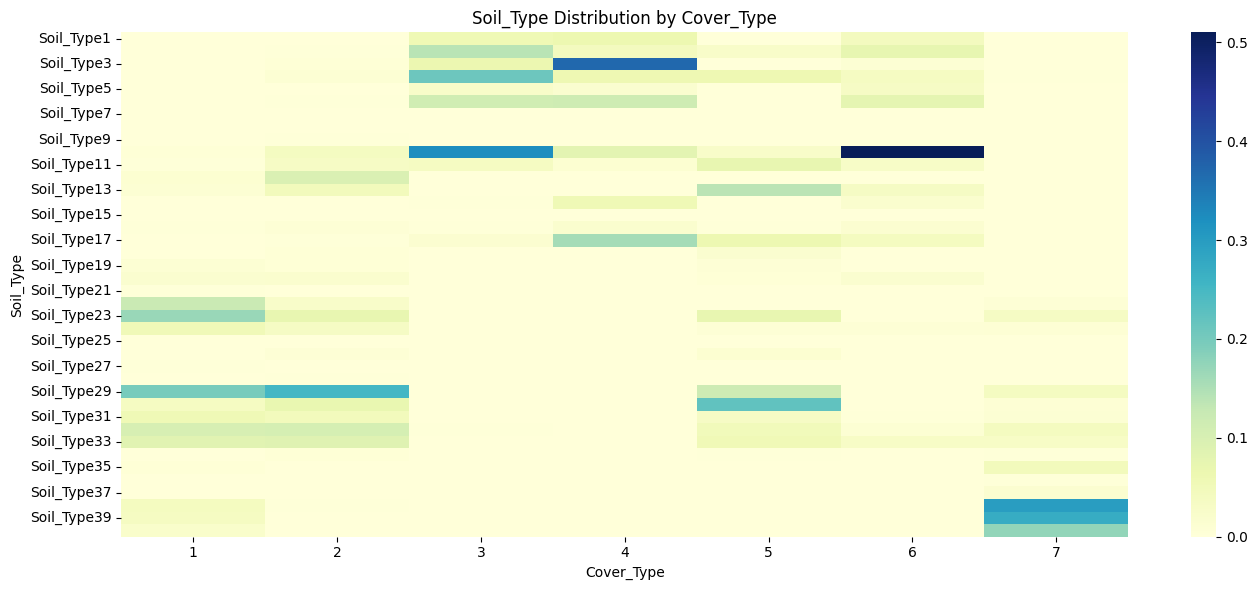

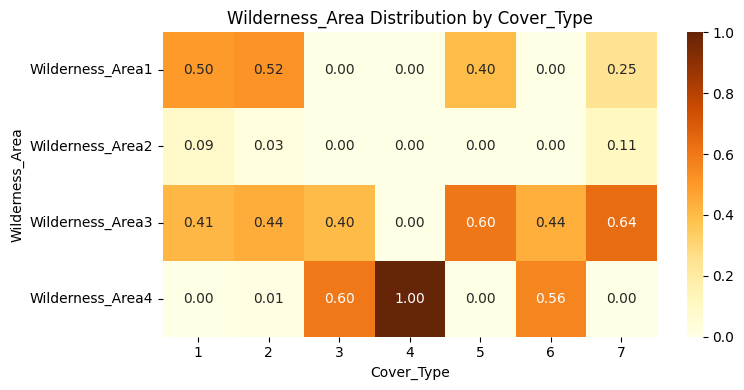

In [14]:
# Select binary columns
soil_cols = [col for col in df.columns if col.startswith("Soil_Type")]
wilderness_cols = [col for col in df.columns if col.startswith("Wilderness_Area")]

# Grouped frequency by Cover_Type (mean of 0/1 indicates percentage of rows in each group)
soil_distribution = df.groupby("Cover_Type")[soil_cols].mean()
wilderness_distribution = df.groupby("Cover_Type")[wilderness_cols].mean()

# Plotting heatmap for Soil_Type
plt.figure(figsize=(14, 6))
sns.heatmap(soil_distribution.T, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Soil_Type Distribution by Cover_Type")
plt.xlabel("Cover_Type")
plt.ylabel("Soil_Type")
plt.tight_layout()
plt.show()

# Plotting heatmap for Wilderness_Area
plt.figure(figsize=(8, 4))
sns.heatmap(wilderness_distribution.T, cmap="YlOrBr", annot=True, fmt=".2f", cbar=True)
plt.title("Wilderness_Area Distribution by Cover_Type")
plt.xlabel("Cover_Type")
plt.ylabel("Wilderness_Area")
plt.tight_layout()
plt.show()

### Distributions of quantitative features

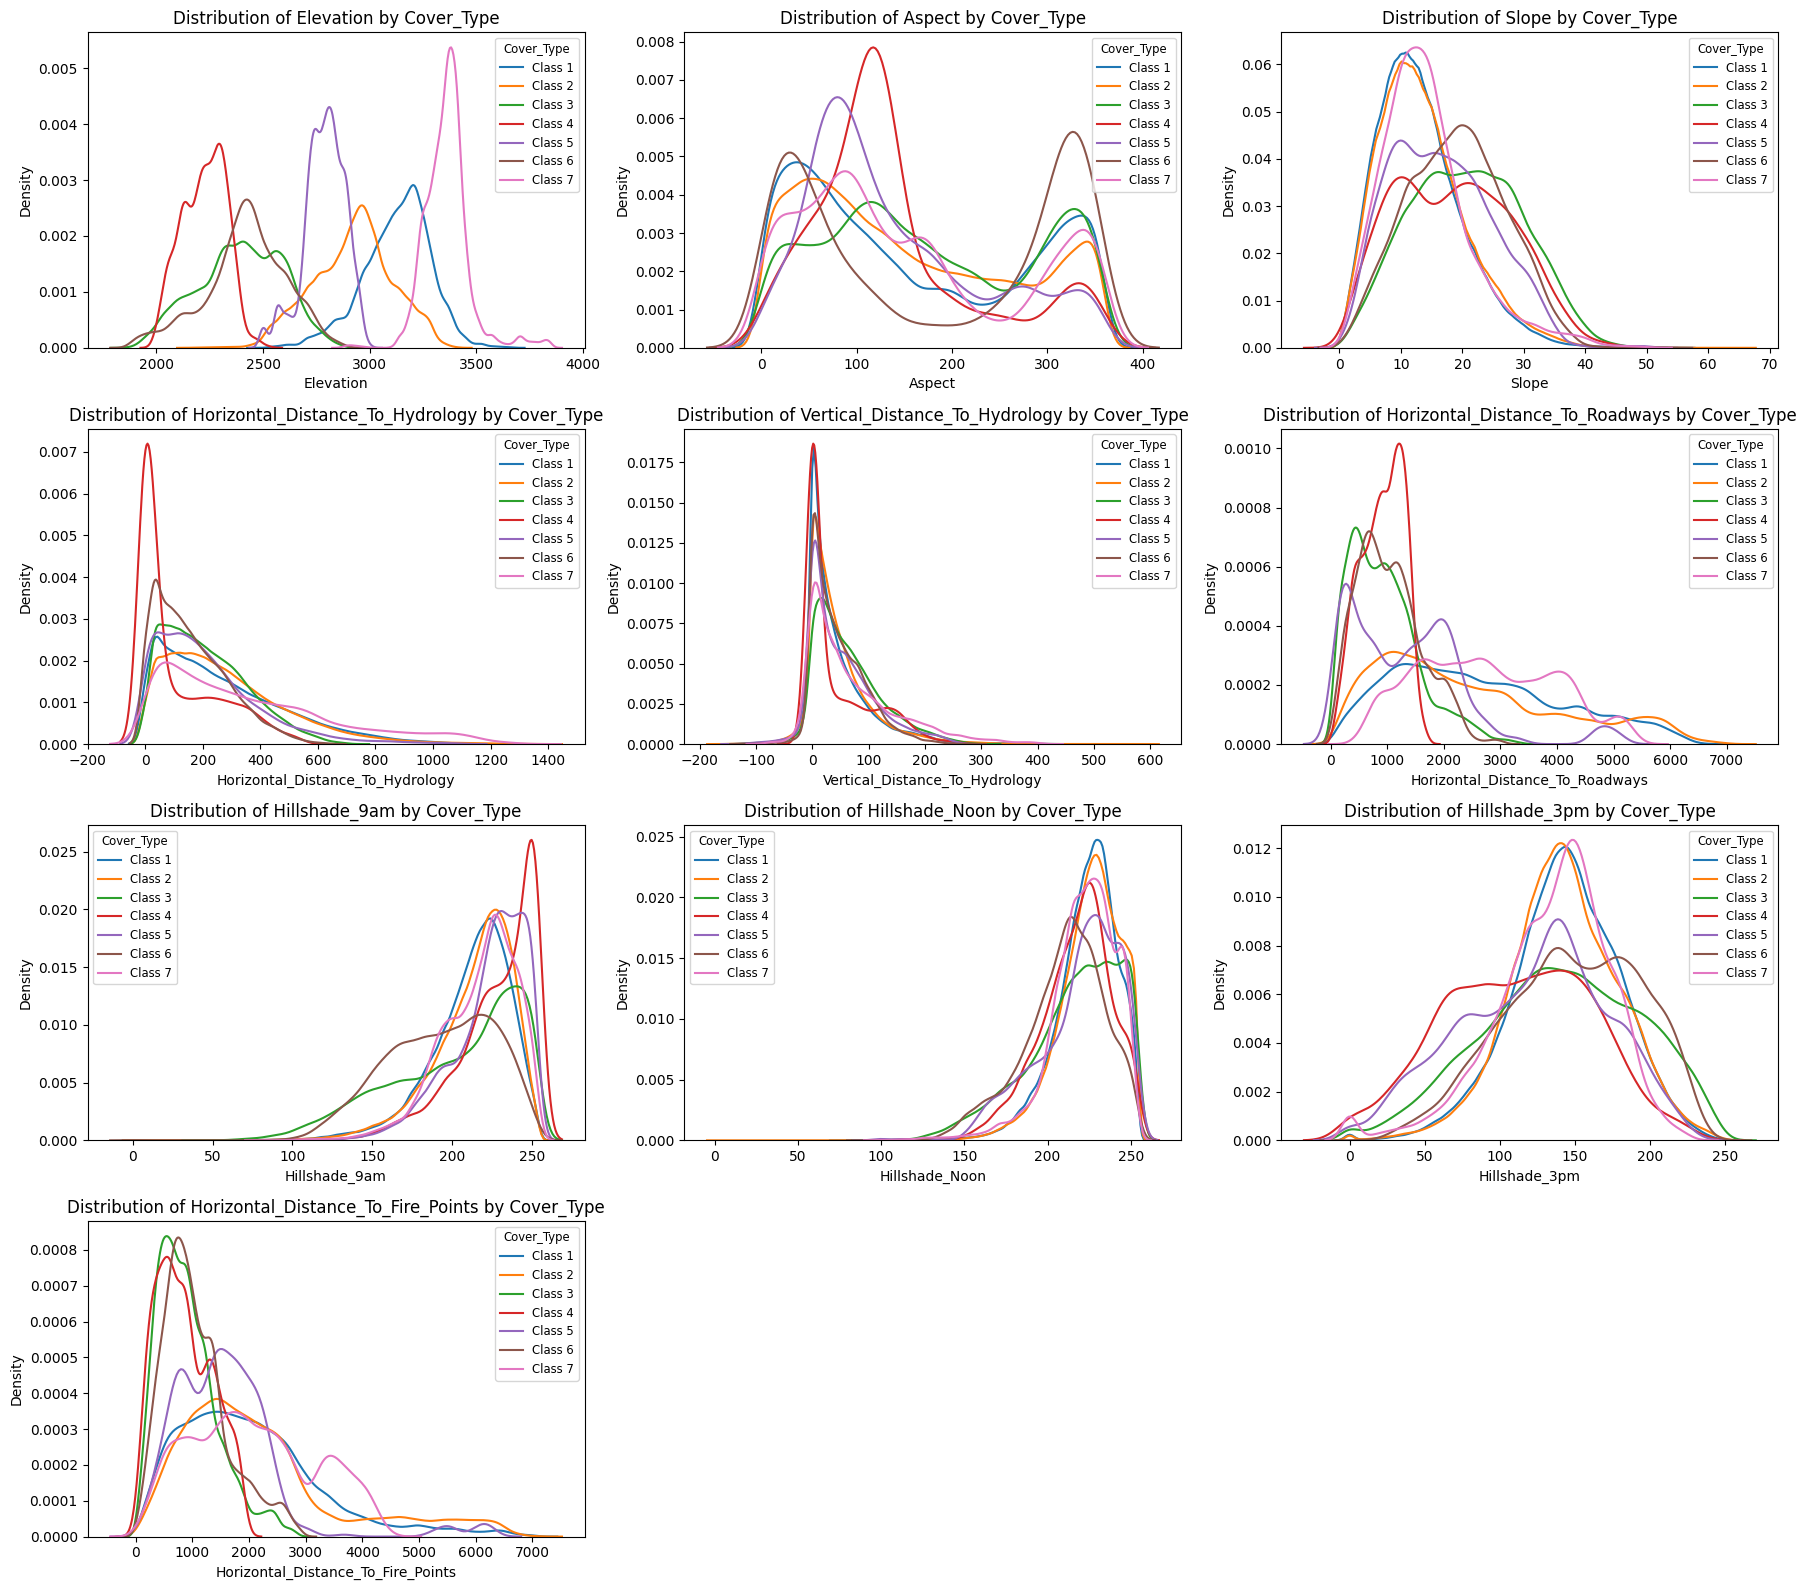

In [15]:
# Define number of classes
class_labels = sorted(df['Cover_Type'].unique())

# Set up plot grid
num_cols = 3
num_rows = int(np.ceil(len(quantitative_cols) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
axes = axes.flatten()

# Plot KDEs for each class
for i, col in enumerate(quantitative_cols):
    for cls in class_labels:
        subset = df[df['Cover_Type'] == cls]
        sns.kdeplot(subset[col], ax=axes[i], label=f"Class {cls}", linewidth=1.5)
    
    axes[i].set_title(f"Distribution of {col} by Cover_Type")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")
    axes[i].legend(title="Cover_Type", fontsize='small', title_fontsize='small')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Boxplots to detect outlier in key feature

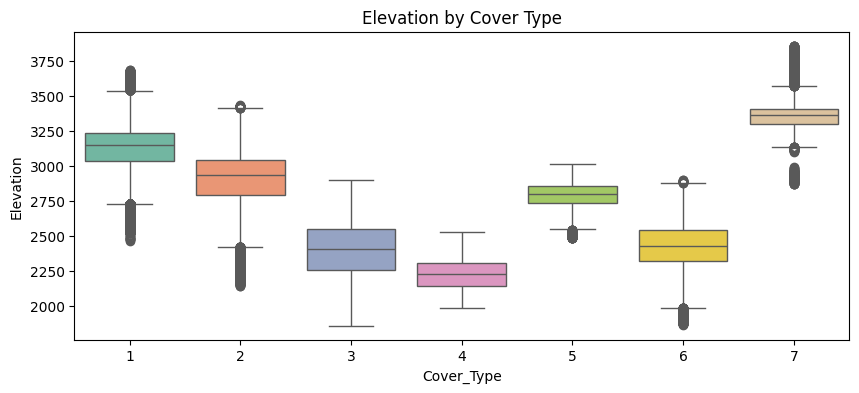

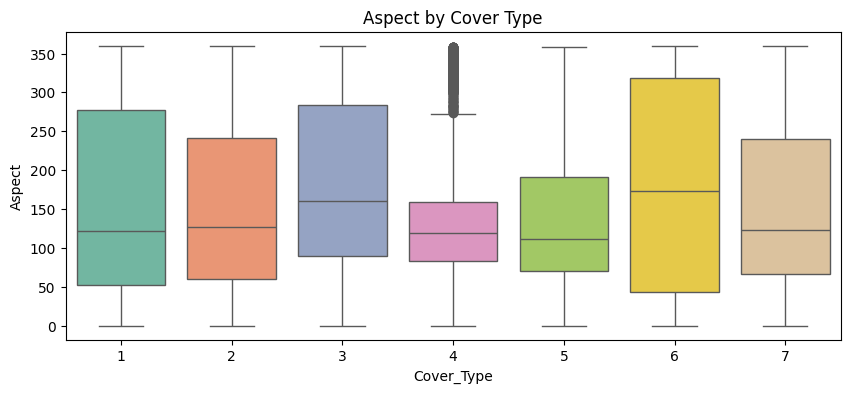

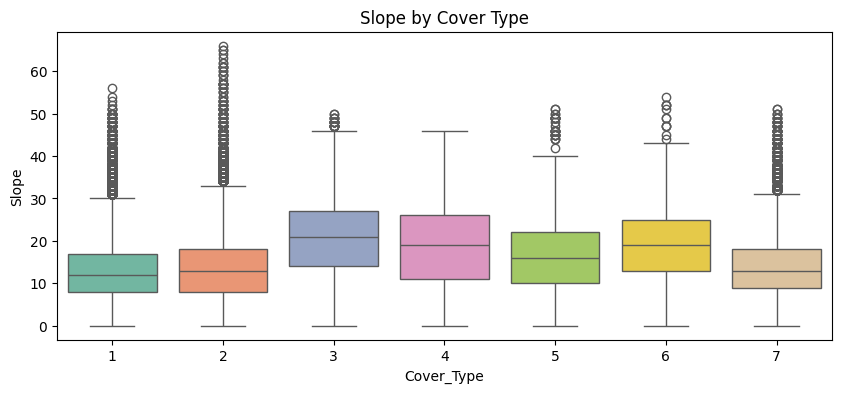

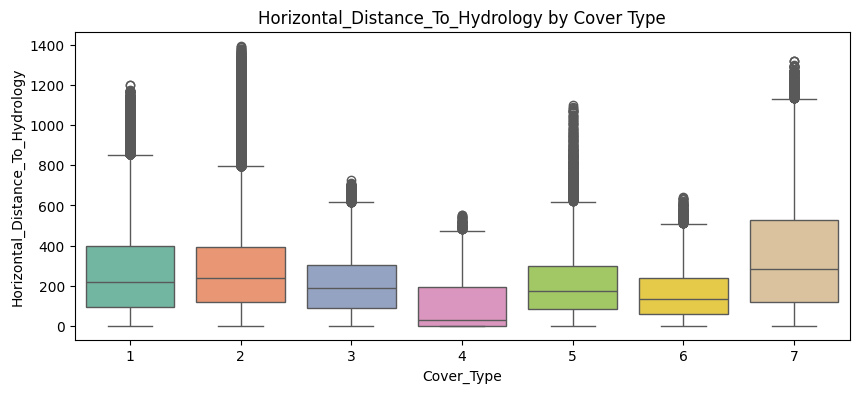

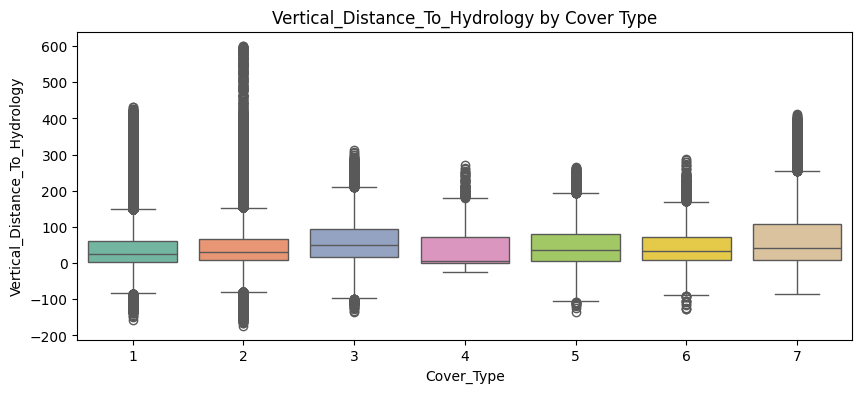

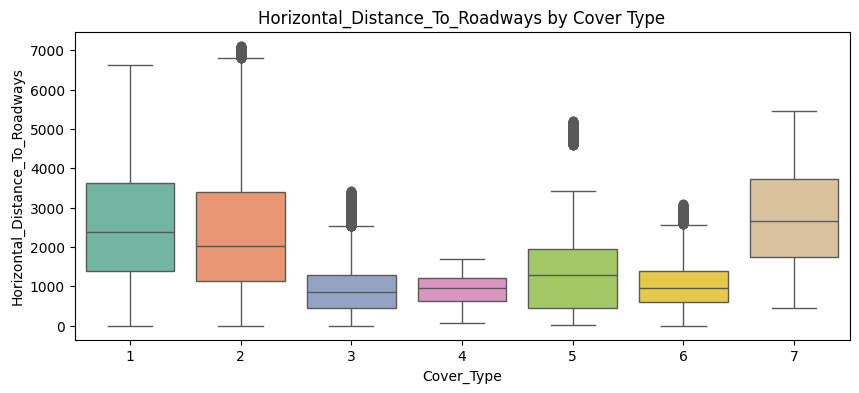

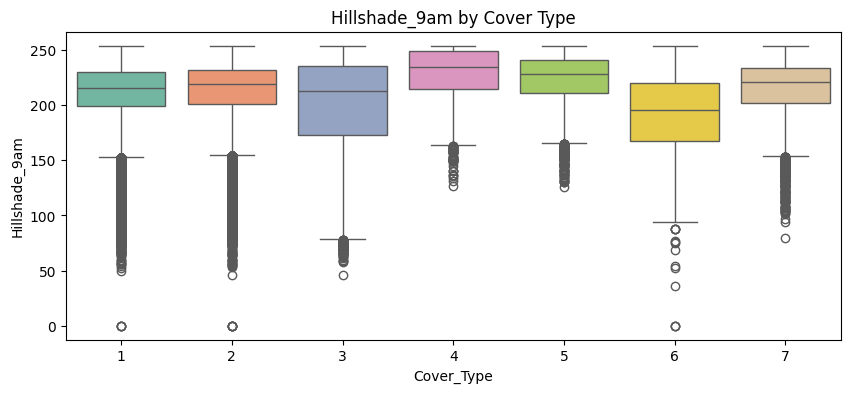

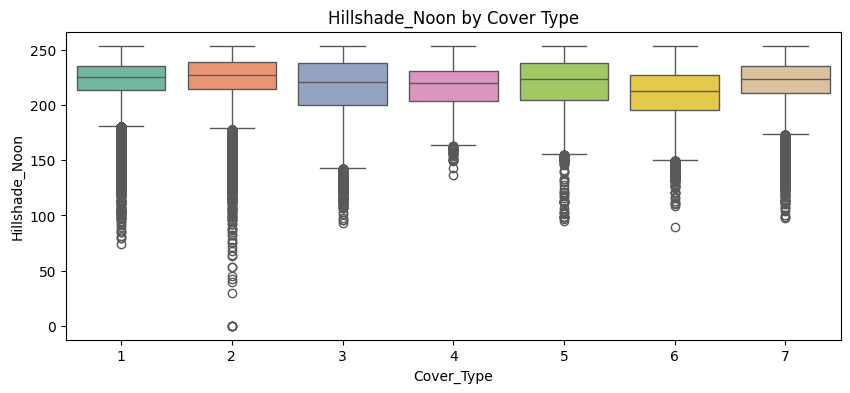

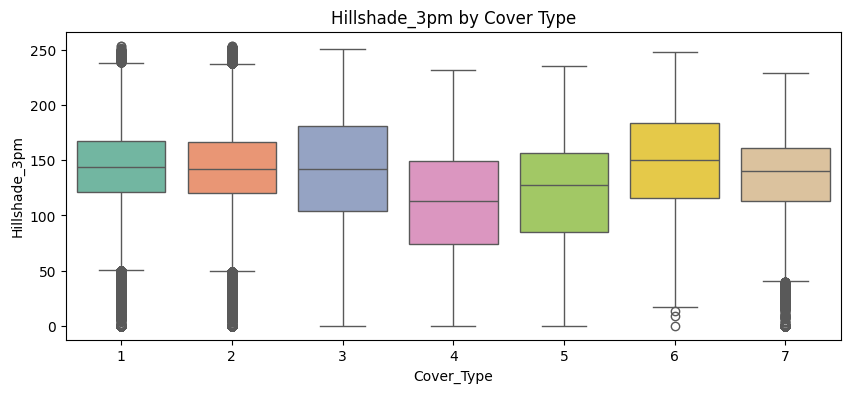

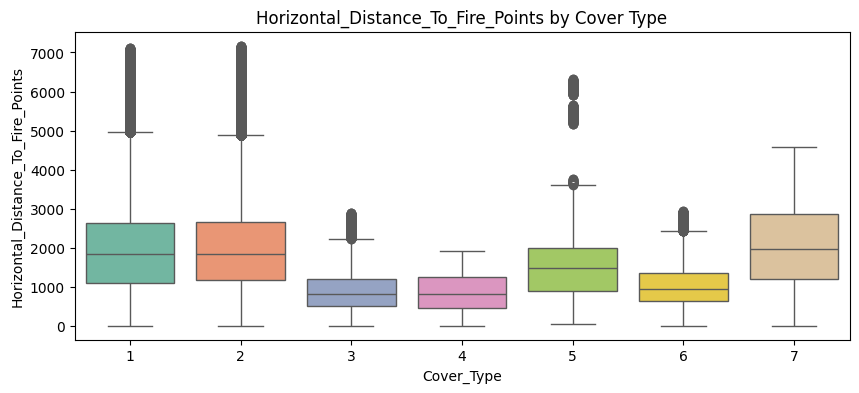

In [16]:
for col in quantitative_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=target_col, y=col, data=df, hue=target_col, palette="Set2", legend=False)
    plt.title(f"{col} by Cover Type")
    plt.show()

## Data visualizazion trough dimensionality reduction


### 🌐 Dimensionality Reduction: PCA, t-SNE, and UMAP

To explore the structure of the dataset in a lower-dimensional space, three dimensionality reduction techniques were applied to the quantitative features:

#### 🔹 PCA (Principal Component Analysis)
The PCA plot shows a smooth, continuous manifold, indicating that PCA captures some global structure. However, the class separation is minimal—most `Cover_Type` classes heavily overlap, suggesting that **PCA is not effective** at revealing distinct clusters in this dataset.

#### 🔹 t-SNE (t-Distributed Stochastic Neighbor Embedding)
t-SNE produces well-separated clusters with clearly defined local groupings. This suggests that t-SNE is effective at preserving **local structure** and highlights potential nonlinear separability between some forest cover types. However, t-SNE does not preserve global distances, so inter-cluster positioning is not meaningful.

#### 🔹 UMAP (Uniform Manifold Approximation and Projection)
UMAP also reveals strong cluster separation and preserves both local and partial global structure. Classes 3 and 4, for example, form distinct, dense regions. UMAP provides a more interpretable global view compared to t-SNE.



### PCA

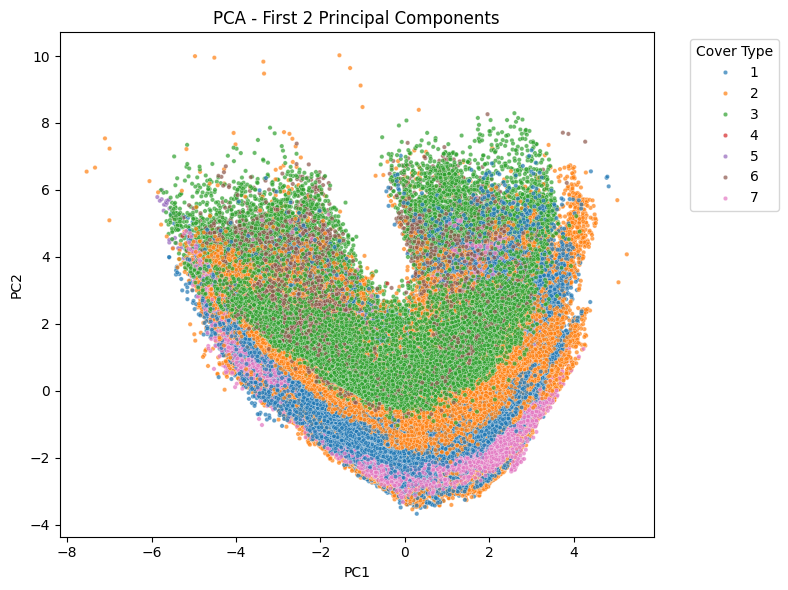

In [28]:
# Scale the quantitative features
X_scaled = StandardScaler().fit_transform(df[quantitative_cols])

# Apply PCA
# Use full SVD solver (numerically more stable)
pca = PCA(n_components=2, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)


# Create a DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca[target_col] = df[target_col].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue=target_col, palette="tab10", s=10, alpha=0.7)
plt.title("PCA - First 2 Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### t-SNE

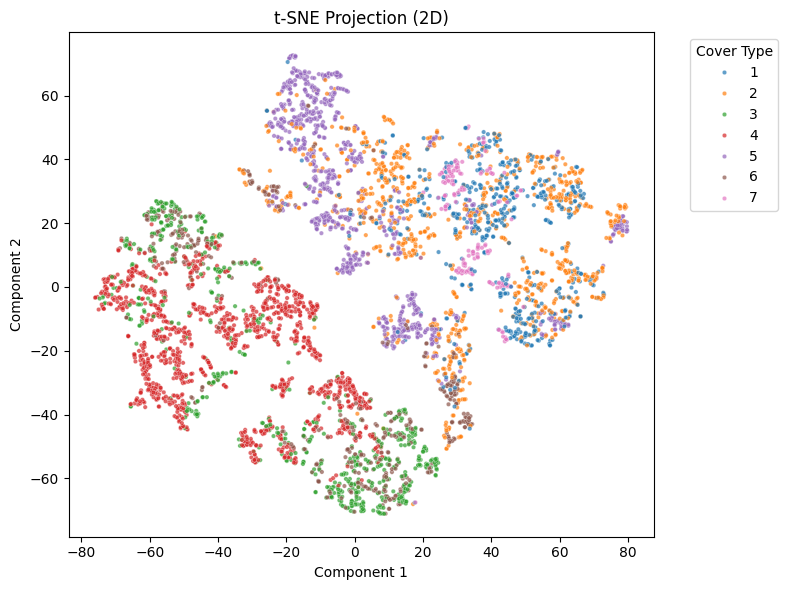

In [30]:

# Suppress runtime warnings temporarily
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    # Optionally disable NumPy warnings too
    np.seterr(all="ignore")

    # Use fewer samples for performance if dataset is large
    n_samples = 5000
    X_sample = X_scaled[:n_samples]
    y_sample = df[target_col].iloc[:n_samples]

    # Run t-SNE with safe parameters
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate='auto',
        max_iter=1000,
        init='pca',
        random_state=42
    )
    X_tsne = tsne.fit_transform(X_sample)

# Reset NumPy warning behavior (optional)
np.seterr(all="warn")

# Plot the result
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_sample, palette="tab10", s=10, alpha=0.7)
plt.title("t-SNE Projection (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### UMAP

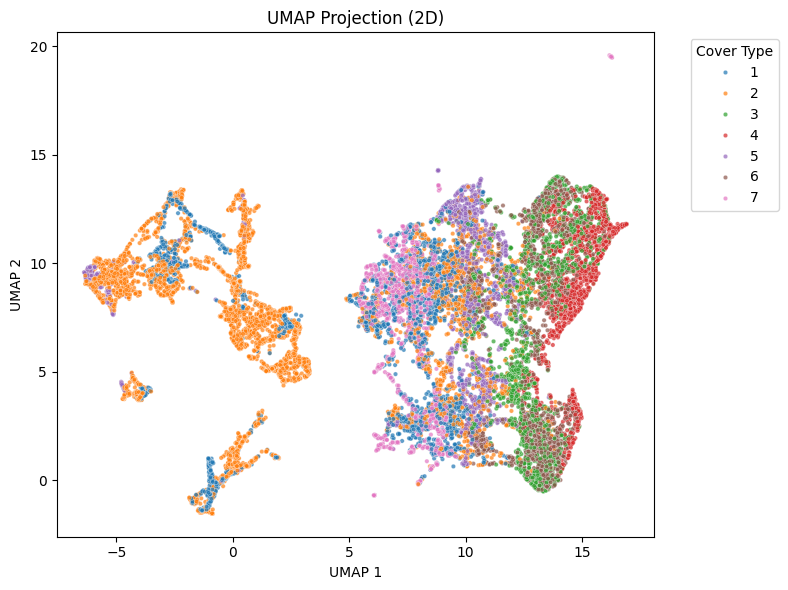

In [ ]:

warnings.filterwarnings("ignore", message=".*omp_set_nested.*")
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden to 1.*", category=UserWarning)

umap_model = umap.UMAP(n_components=2, random_state=RANDOM_SEED)
X_umap = umap_model.fit_transform(X_scaled[:5000])
y_umap = df["Cover_Type"].iloc[:5000]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_umap, palette="tab10", s=10, alpha=0.7)
plt.title("UMAP Projection (2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Classifiers

### 🧠 Model Selection Justification

This dataset exhibits several characteristics that directly influence model effectiveness:

- **Mixed data types**: It contains both **continuous features** (e.g., Elevation, Slope, Hillshade) and **high-dimensional binary features** (e.g., `Soil_TypeX`, `Wilderness_AreaX`).
- **High cardinality in binary features**: The presence of 40 soil types benefits models that can handle **sparse, one-hot encoded inputs** effectively.
- **Nonlinear relationships**: Variables such as `Elevation`, `Hillshade`, and `Distance to Hydrology` are likely to influence the target in a nonlinear fashion.
- **Multiclass classification**: The target has **seven distinct forest cover types**, requiring models that support multiclass classification and can balance class-specific performance.
- **Slight class imbalance**: Some classes appear more frequently than others, making metrics like **recall** and **G-Mean** important for evaluation.

Given these properties, the following model types are most appropriate:

#### ✅ Recommended:
- **Tree-based models** (e.g., Random Forest, XGBoost): These models naturally handle mixed feature types, model nonlinear relationships, and are robust to class imbalance.
- **K-Nearest Neighbors**: Performs reasonably well due to sensitivity to local feature patterns, though scalability may be a limitation for larger datasets.

#### ⚠️ Less Suitable:
- **Linear models** (e.g., Logistic Regression, Linear SVM): These are useful as interpretable baselines but often fail to capture the complexity of nonlinear, high-dimensional relationships.
- **Naive Bayes**: Assumes independence among features, which is unrealistic in this dataset given environmental and spatial dependencies.
- **Kernel-based SVMs**: Their high computational cost and poor performance in this case make them impractical without advanced tuning or dimensionality reduction.

---

### 📊 Model Performance Comparison and Insights

The table below compares the performance of multiple ML models using several evaluation metrics: **Accuracy**, **F1 Score**, **G-Mean**, **Recall**, and **Specificity**. This helps assess both overall and per-class model behavior.

#### 🔹 Top Performing Models:
- **Random Forest** (both standard and balanced variants) leads in every metric, with over **95% accuracy and F1**, and excellent per-class balance.
- **K-Nearest Neighbors** also performs strongly, achieving above **92% accuracy** and solid G-Mean and recall.
- **XGBoost**, while slightly lower in raw accuracy (~87%), maintains **strong class balance**, with high G-Mean and decent recall.

#### 🔸 Moderate Models:
- **Logistic Regression** and **Linear SVMs** perform acceptably but struggle with **recall and G-Mean**, suggesting weaker performance on minority classes.
- **Balanced variants** of these models help boost recall but typically reduce precision and overall F1.

#### 🔻 Weak Performers:
- **Standard and balanced SVM (non-linear kernels)** and **Naive Bayes** perform poorly, with very low F1 and G-Mean scores. This reflects their inability to manage the complexity and dimensionality of the dataset without significant preprocessing.

#### 📝 Additional Observations:
- The **use of class weighting (balanced versions)** had mixed effects. While it improved recall in underrepresented classes, it often **reduced overall accuracy and F1**, especially in models like SVM.

---

### ✅ Conclusion

Given the structure of the dataset, **Random Forest** and **XGBoost** are the most effective models — they handle the mix of continuous and binary features well, require minimal preprocessing, and yield high and balanced performance. Simpler models are useful for interpretability or benchmarking but are not suitable for production-level performance in this case.

### Train-test split

In [ ]:
X_quant = df[quantitative_cols]
X_binary = df[binary_cols]
y = df[target_col] - 1  # Convert labels from 1–7 to 0–6

# Train-test split
X_train_q, X_test_q, X_train_bin, X_test_bin, y_train, y_test = train_test_split(
    X_quant, X_binary, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

### Feature scaling

In [ ]:
# Scale only the quantitative features
scaler = StandardScaler()
X_train_q_scaled = scaler.fit_transform(X_train_q)
X_test_q_scaled = scaler.transform(X_test_q)

# Concatenate scaled quantitative with binary features
X_train = np.hstack([X_train_q_scaled, X_train_bin])
X_test = np.hstack([X_test_q_scaled, X_test_bin])

### Model Definition

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=100),
    "Logistic Regression - Balanced": LogisticRegression(max_iter=100, class_weight='balanced'),

    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    "Random Forest - Balanced": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_SEED),

    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "LinearSVC": LinearSVC(max_iter=100),
    "LinearSVC - Balanced": LinearSVC(max_iter=100, class_weight='balanced'),

    "Support Vector Machine": SVC(max_iter=100),
    "Support Vector Machine - Balanced": SVC(max_iter=100, class_weight='balanced'),

    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
}

### Train and evaluate each model

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
trained_models = train_models(models, X_train, y_train)
results = evaluate_models(trained_models, X_test, y_test)

### Results summary

In [ ]:
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\n📊 Model Performance Comparison:")
print(results_df)


### Visualize model performance

In [ ]:
sns.barplot(data=results_df, x="F1 Score", y="Model", palette="viridis")
plt.title("F1 Score by Model")
plt.xlabel("F1 Score (weighted)")
plt.ylabel("Model")
plt.show()

## 🚀 Possible Next Steps to Improve the Project

1. **Hyperparameter Optimization**  
   Improve the performance and robustness of the machine learning models by implementing hyperparameter tuning using:
   - `GridSearchCV` or `RandomizedSearchCV` from `scikit-learn`
   - Cross-validation to ensure generalization and avoid overfitting

2. **Feature Attribution and Interpretability**  
   Apply feature attribution methods to gain insights into model decision-making:
   - **SHAP (SHapley Additive exPlanations)** for model-agnostic interpretability
   - **Permutation importance** for simple, intuitive feature ranking
   - Consider **LIME** or **Integrated Gradients** for deep learning models

These enhancements can lead to more accurate, explainable, and actionable results.